In [ ]:
!pip install transformers hydra_core omegaconf
!pip install wikipedia

In [ ]:
from transformers import pipeline
unmasker1 = pipeline('fill-mask', model='roberta-large') # distilbert-base-uncased("[MASK]")     or      roberta-base("<mask>")          or    albert-base-v2("[MASK]")
unmasker2 = pipeline('fill-mask', model='distilbert-base-uncased') # distilbert-base-uncased("[MASK]")     or      roberta-base("<mask>")
import re
import spacy
sp = spacy.load('en_core_web_sm')
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
import string 
import wikipedia
nlp = spacy.load("en_core_web_sm")

maskString = "<mask>"

In [ ]:
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

In [ ]:
def seperateCharacters(userInput):
  
  pat = re.compile(r"([,:;@#$%&^.()!?])")

  
  userInput = pat.sub(" \\1 ", userInput)
  words = userInput.split()

  return words

In [ ]:
def findAccuracy (userInput): 

  text = userInput

  list1 = seperateCharacters(text)
  list3 = seperateCharacters(text)

  numberSuperScripts = ["st", "nd", "rd", "th"]

  

  rating = 0

  for i in range(len(list1)):

    for j in range(len(numberSuperScripts)):
      if (list1[i].find(numberSuperScripts[j]) != -1 and list1[i].isalpha() is False):
        list1[i] = list1[i].replace(numberSuperScripts[j], "")

    sen = nlp(list1[i])

    if (sen[0].pos_ == 'NUM'):
      maskString = "[MASK]"
    else:
      maskString = "<mask>"

    list2 = list1.copy()
    list2[i] = maskString

    newString = listToString(list2)

    if (sen[0].pos_ == 'NUM'):
      preds = unmasker2(newString)
    else:
      preds = unmasker1(newString)

    j = 0
    k = 0

    for pred in preds:

      if (k == 0):
        list1[i] = pred["token_str"]
        k = 1
      
      string2 = list3[i].lower()
      string_length = len(string2) + 1 
      string_revised=string2.rjust(string_length)


      if (string_revised == pred["token_str"].lower() or list3[i].lower() == pred["token_str"].lower()):
       
        break
      else: 
        j += 1

    rating += 1 - (0.2 * (j))

  total = rating / (i + 1)

  return listToString(list1), total



In [ ]:
def combineString(userInput):

  userInput = listToString(userInput)

  for i in userInput:
    if i in string.punctuation:
      userInput[i-1] = ""

In [ ]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        #printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    #print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(25,25))
    nx.draw(G, pos, edge_color='black', width=3, linewidths=1,
            node_size=200, node_color='seagreen', font_size = 12, alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')

    plt.show()


In [ ]:
def sentenceCorrection(userText, inncorrectWords):

  i = 0
  j = 0
  word = seperateCharacters(userInput)
  predRating = 0
  predString = ""
  newInput = ""
  correctedString = ""
  replaceWords = []

  for i in range(len(inncorrectWords)):
    
    predRating = 0
    predString = ""

    doc = nlp(word[inncorrectWords[i]])

    if (doc[0].ent_type_ == "PERSON"):
      continue

    maskList = word.copy()

    """
    maskList[inncorrectWords[i]] = maskString
    newInput = listToString(maskList)

    preds = unmasker(newInput)

    """
    
    
    
    if (doc[0].ent_type_ == "GPE"):

      maskString = "<mask>"

      maskList[inncorrectWords[i]] = maskString
      newInput = listToString(maskList)

      preds = unmasker2(newInput)
    else:
      maskString = "[MASK]"

      maskList[inncorrectWords[i]] = maskString
      newInput = listToString(maskList)

      preds = unmasker1(newInput)

    
    
    for pred in preds:

      for k in range(len(preds)):


        if (pred["score"] > predRating):
          predRating = pred["score"]
          predString = pred["token_str"]
    

    replaceWords.append(predString)
    word[inncorrectWords[j]] = replaceWords[j]
    j += 1

    
  
 
  newInput = listToString(word)


  return newInput

In [ ]:
def wikiTokens (input):


  token_text = ""
  token = wikipedia.page(input, auto_suggest=True)

  for content_line in token.content.split("\n"):
    if "==" in content_line:
      break
    token_text += content_line

  
  list = input.split()
  token_text = ""


  for i in range(len(list)):
    token = wikipedia.page(list[i])

    for content_line in token.content.split("\n"):
      if "==" in content_line:
        break
      token_text += content_line
    
  return token_text


In [ ]:
userInput = input("Enter your text: ") 
accuracy = findAccuracy(userInput)
print("\nModule Prediction accuracy rating (0 - 1): ", accuracy[1], "\n", 
      "Module Prediction accuracy rating (%):    ", accuracy[1] * 100, "%\n\n",
      "Corrected String:    ", accuracy[0])

if accuracy[1] * 100 >= 85:
  print("\nClaim is valid\n\n")
else:
  print("\nClaim is invalid\n\n")


correctedString = accuracy[0]

text = ""

list1 = seperateCharacters(correctedString)
list2 = seperateCharacters(userInput)

disregardList = ["a", "an", "the", "to", "as", "was",
                "then", "that", "which", "are", "on",
                 "is", "of", "in"]


for i in range(len(list1)):

  sen = sp(list1[i])

  if (sen[0].pos_ == 'PROPN'):

    if ("-" in list1[i]):
      list1[i] = list1[i].replace("-", " ")

    try:
      text += wikiTokens(list1[i])
    except (wikipedia.DisambiguationError, wikipedia.exceptions.PageError) as e:
      print("DisambiguationError with", list1[i])
      continue 

  sentences = getSentences(text)
  nlp_model = spacy.load('en_core_web_sm')
  


sentences = getSentences(text)

triples = []
print(text)
for sentence in sentences:
    triples.append(processSentence(sentence))

printGraph(triples)




# Output Document August 2, 2021 (using distilbert and RoBERTa-Large)

```
Barack Obama is the 51st prime-minister of the United States.

Module prediction accuracy rating (0 - 1):  0.8 
 Module Predicition accuracy rating (%):     80.0 %

 Corrected String:     President  Obama  is  the 44th  President  of  the  United  States .
President
DisambiguationError with President
Obama
President
DisambiguationError with President
United
DisambiguationError with United
```
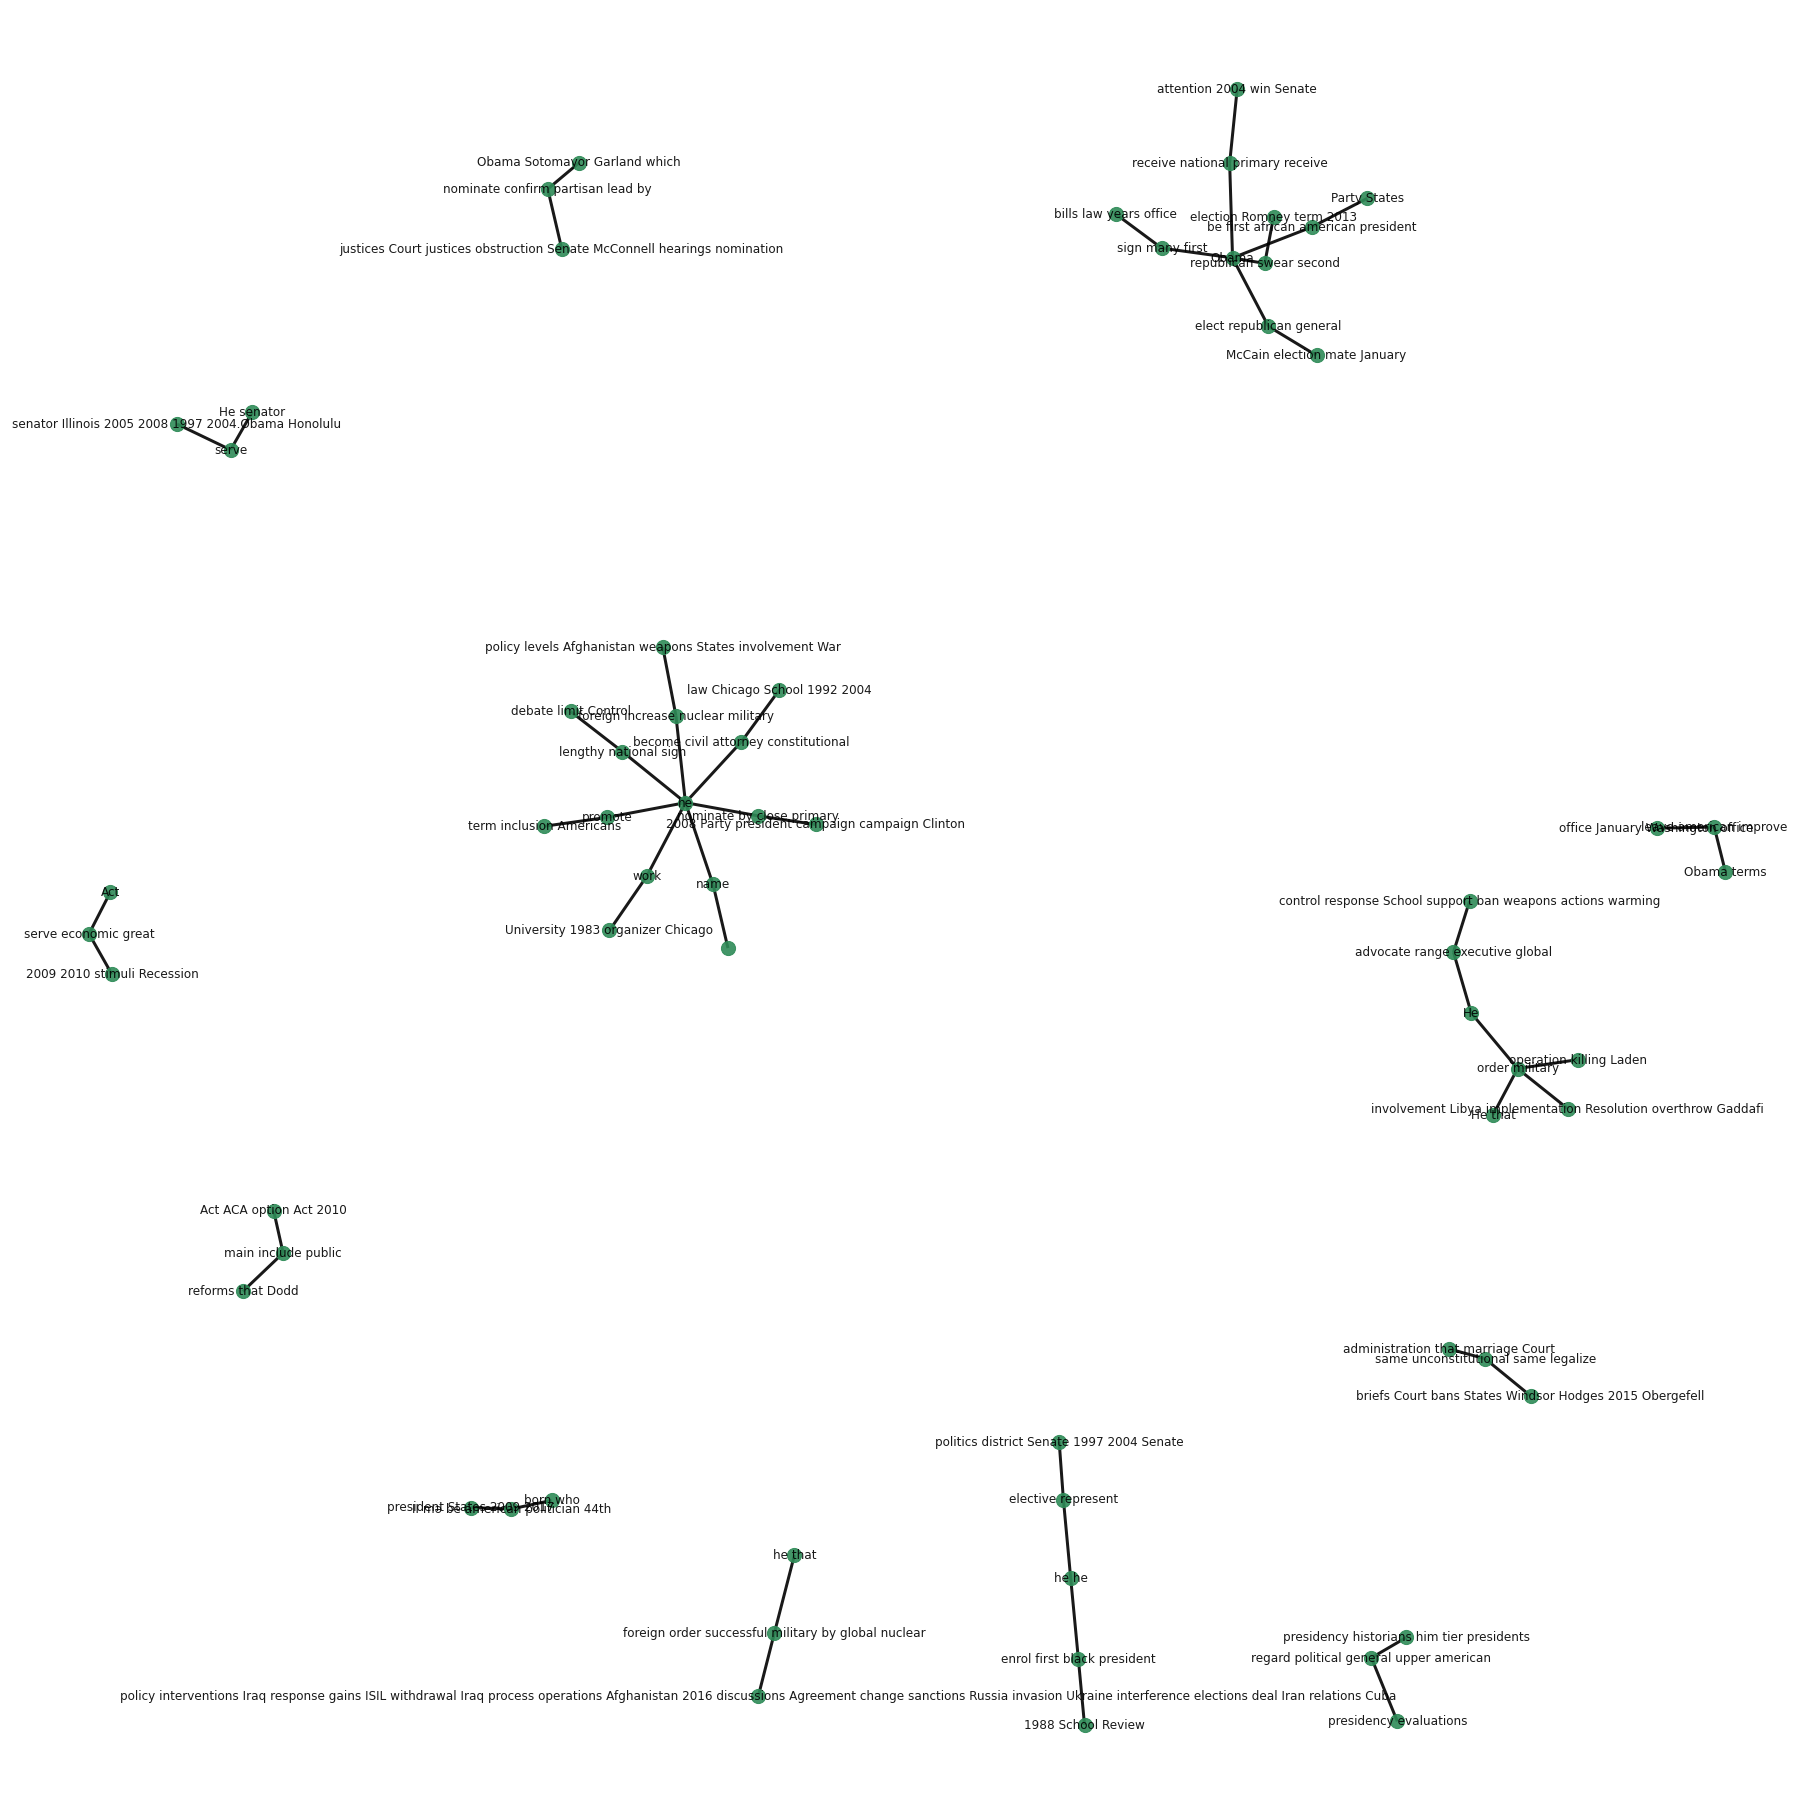

```
Neil Armstrong, an astronaut, was the first man on the moon.

Module prediction accuracy rating (0 - 1):  0.9857142857142858 
 Module Predicition accuracy rating (%):     98.57142857142858 %

 Corrected String:     Neil  Armstrong ,  NASA  astronaut ,  was  the  first  man  on  the  moon .
Neil
Armstrong
DisambiguationError with Armstrong
NASA
astronaut
moon
```

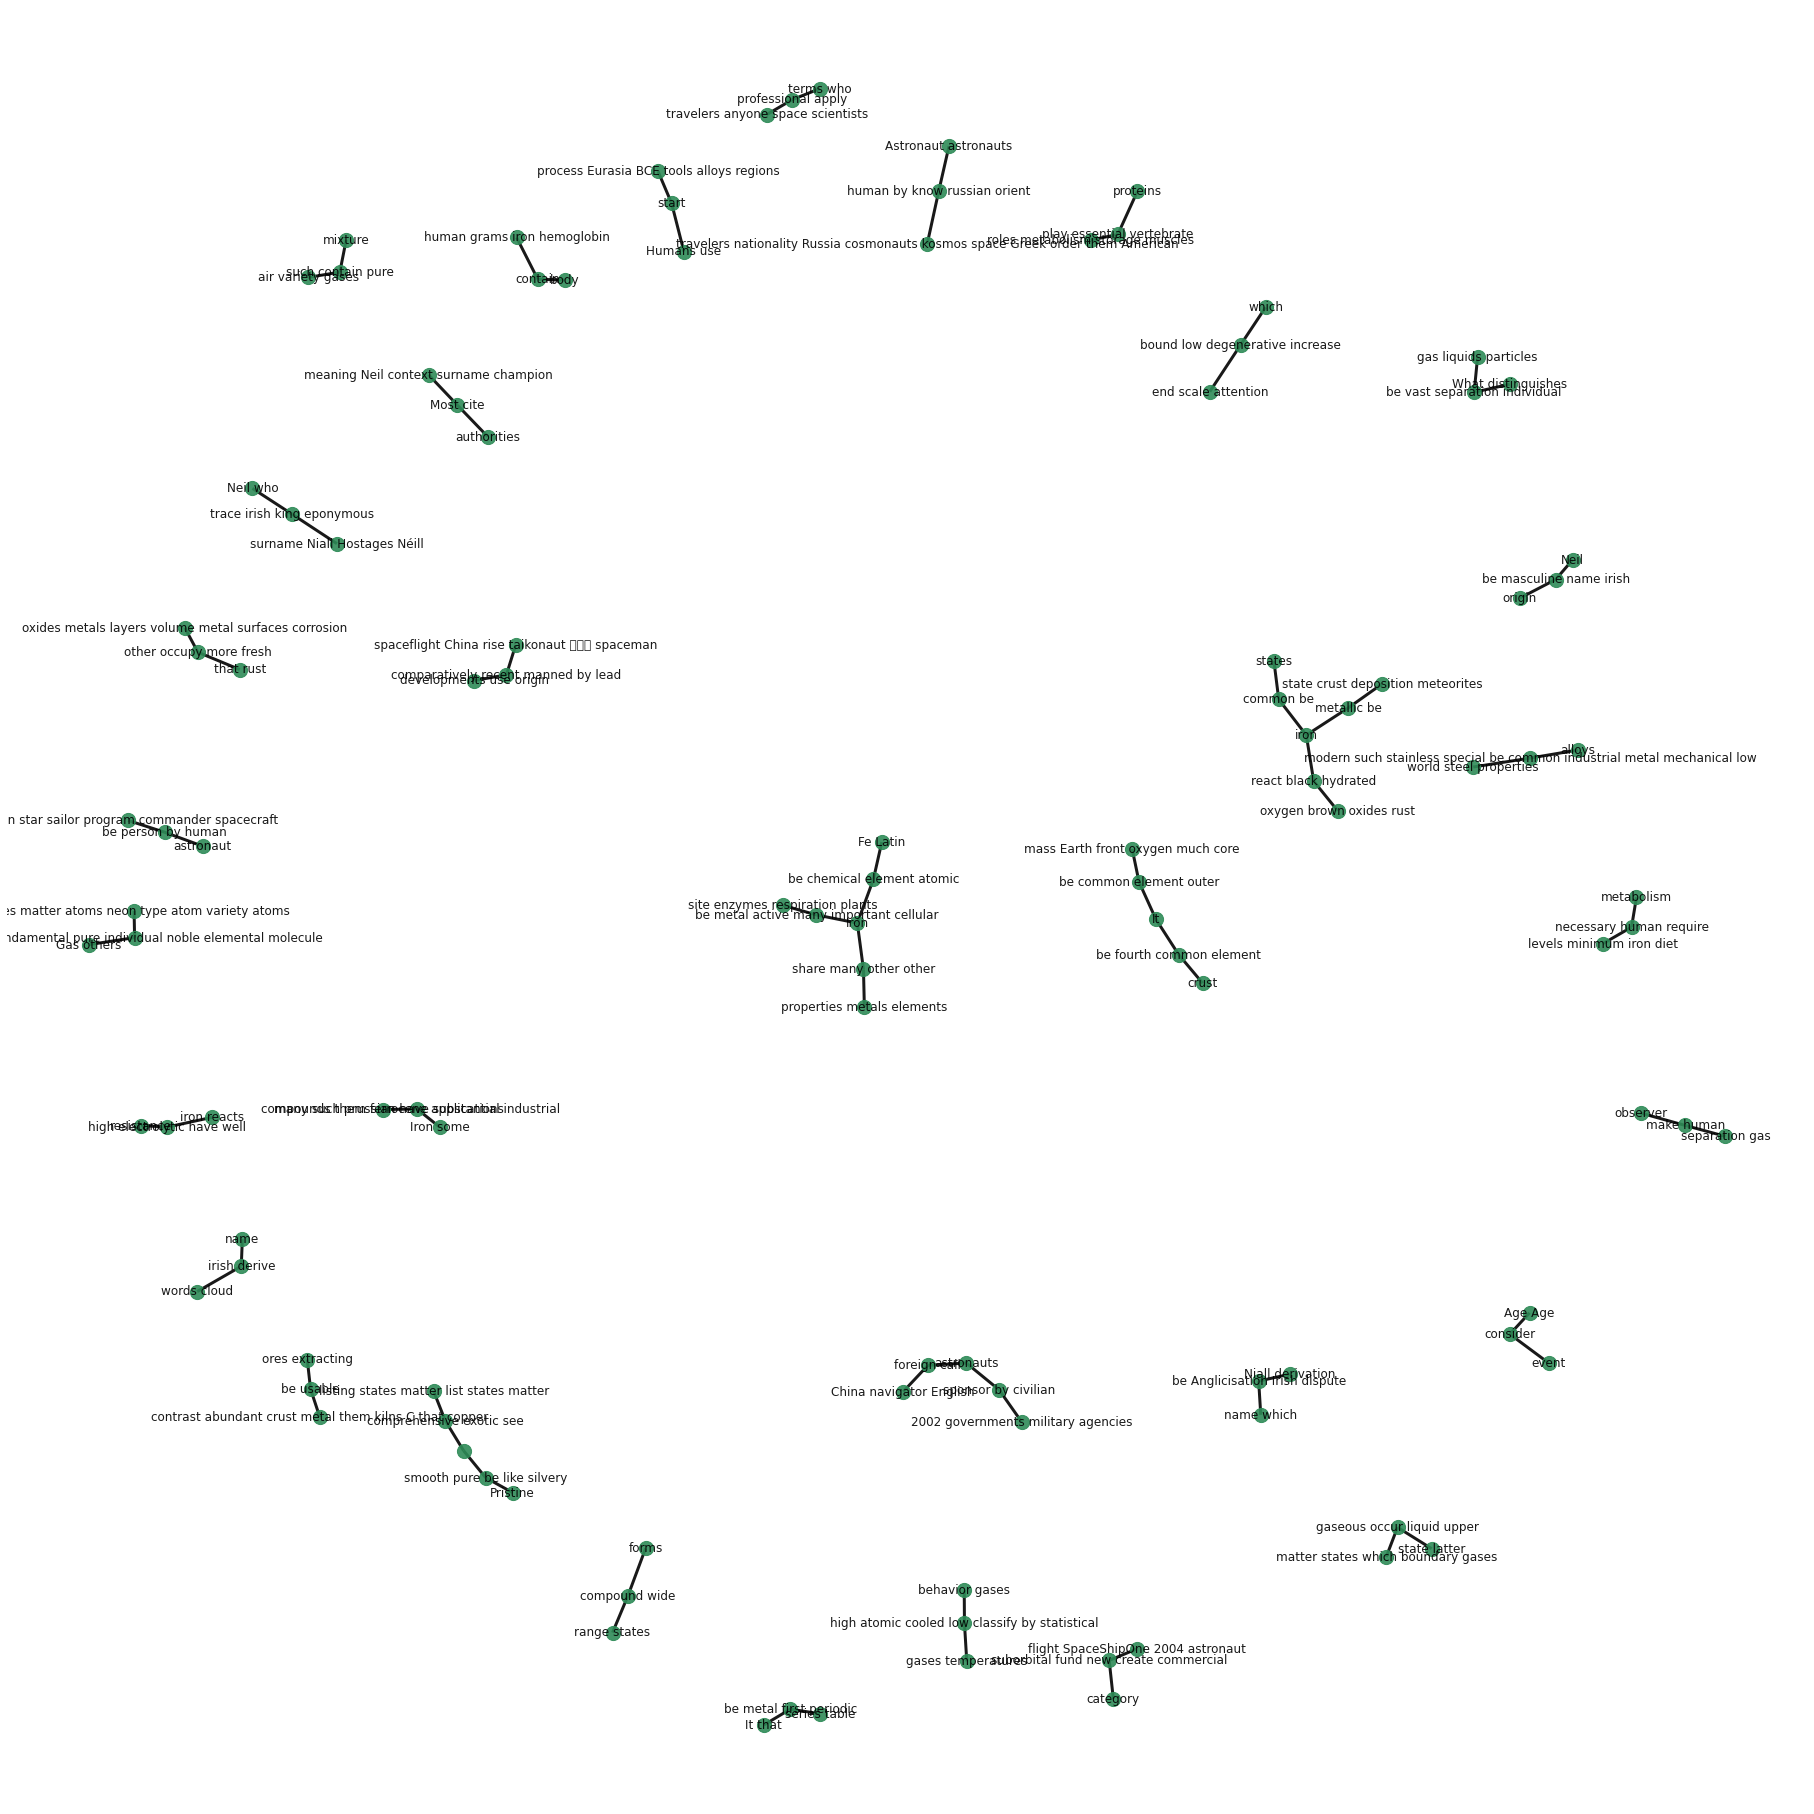

```
Albert Einstein was a German physicist, widely acknowledged to be one of the greatest physicists of all time. Einstein is known for developing the theory of relativity, but he also made important contributions to the development of the theory of quantum mechanics.

Module prediction accuracy rating (0 - 1):  0.9304347826086957 
 Module Predicition accuracy rating (%):     93.04347826086958 %

 Corrected String:     Albert  Einstein  was  a  German  physicist ,  widely  considered  to  be one  of  the  greatest  minds  of  all   .  He  is  known  for    his  theory  of  relativity ,  but  he  also  made    contributions  to  the  development  of  the  theory  of    gravity .
Albert
DisambiguationError with Albert
Einstein
German
DisambiguationError with German
physicist
```
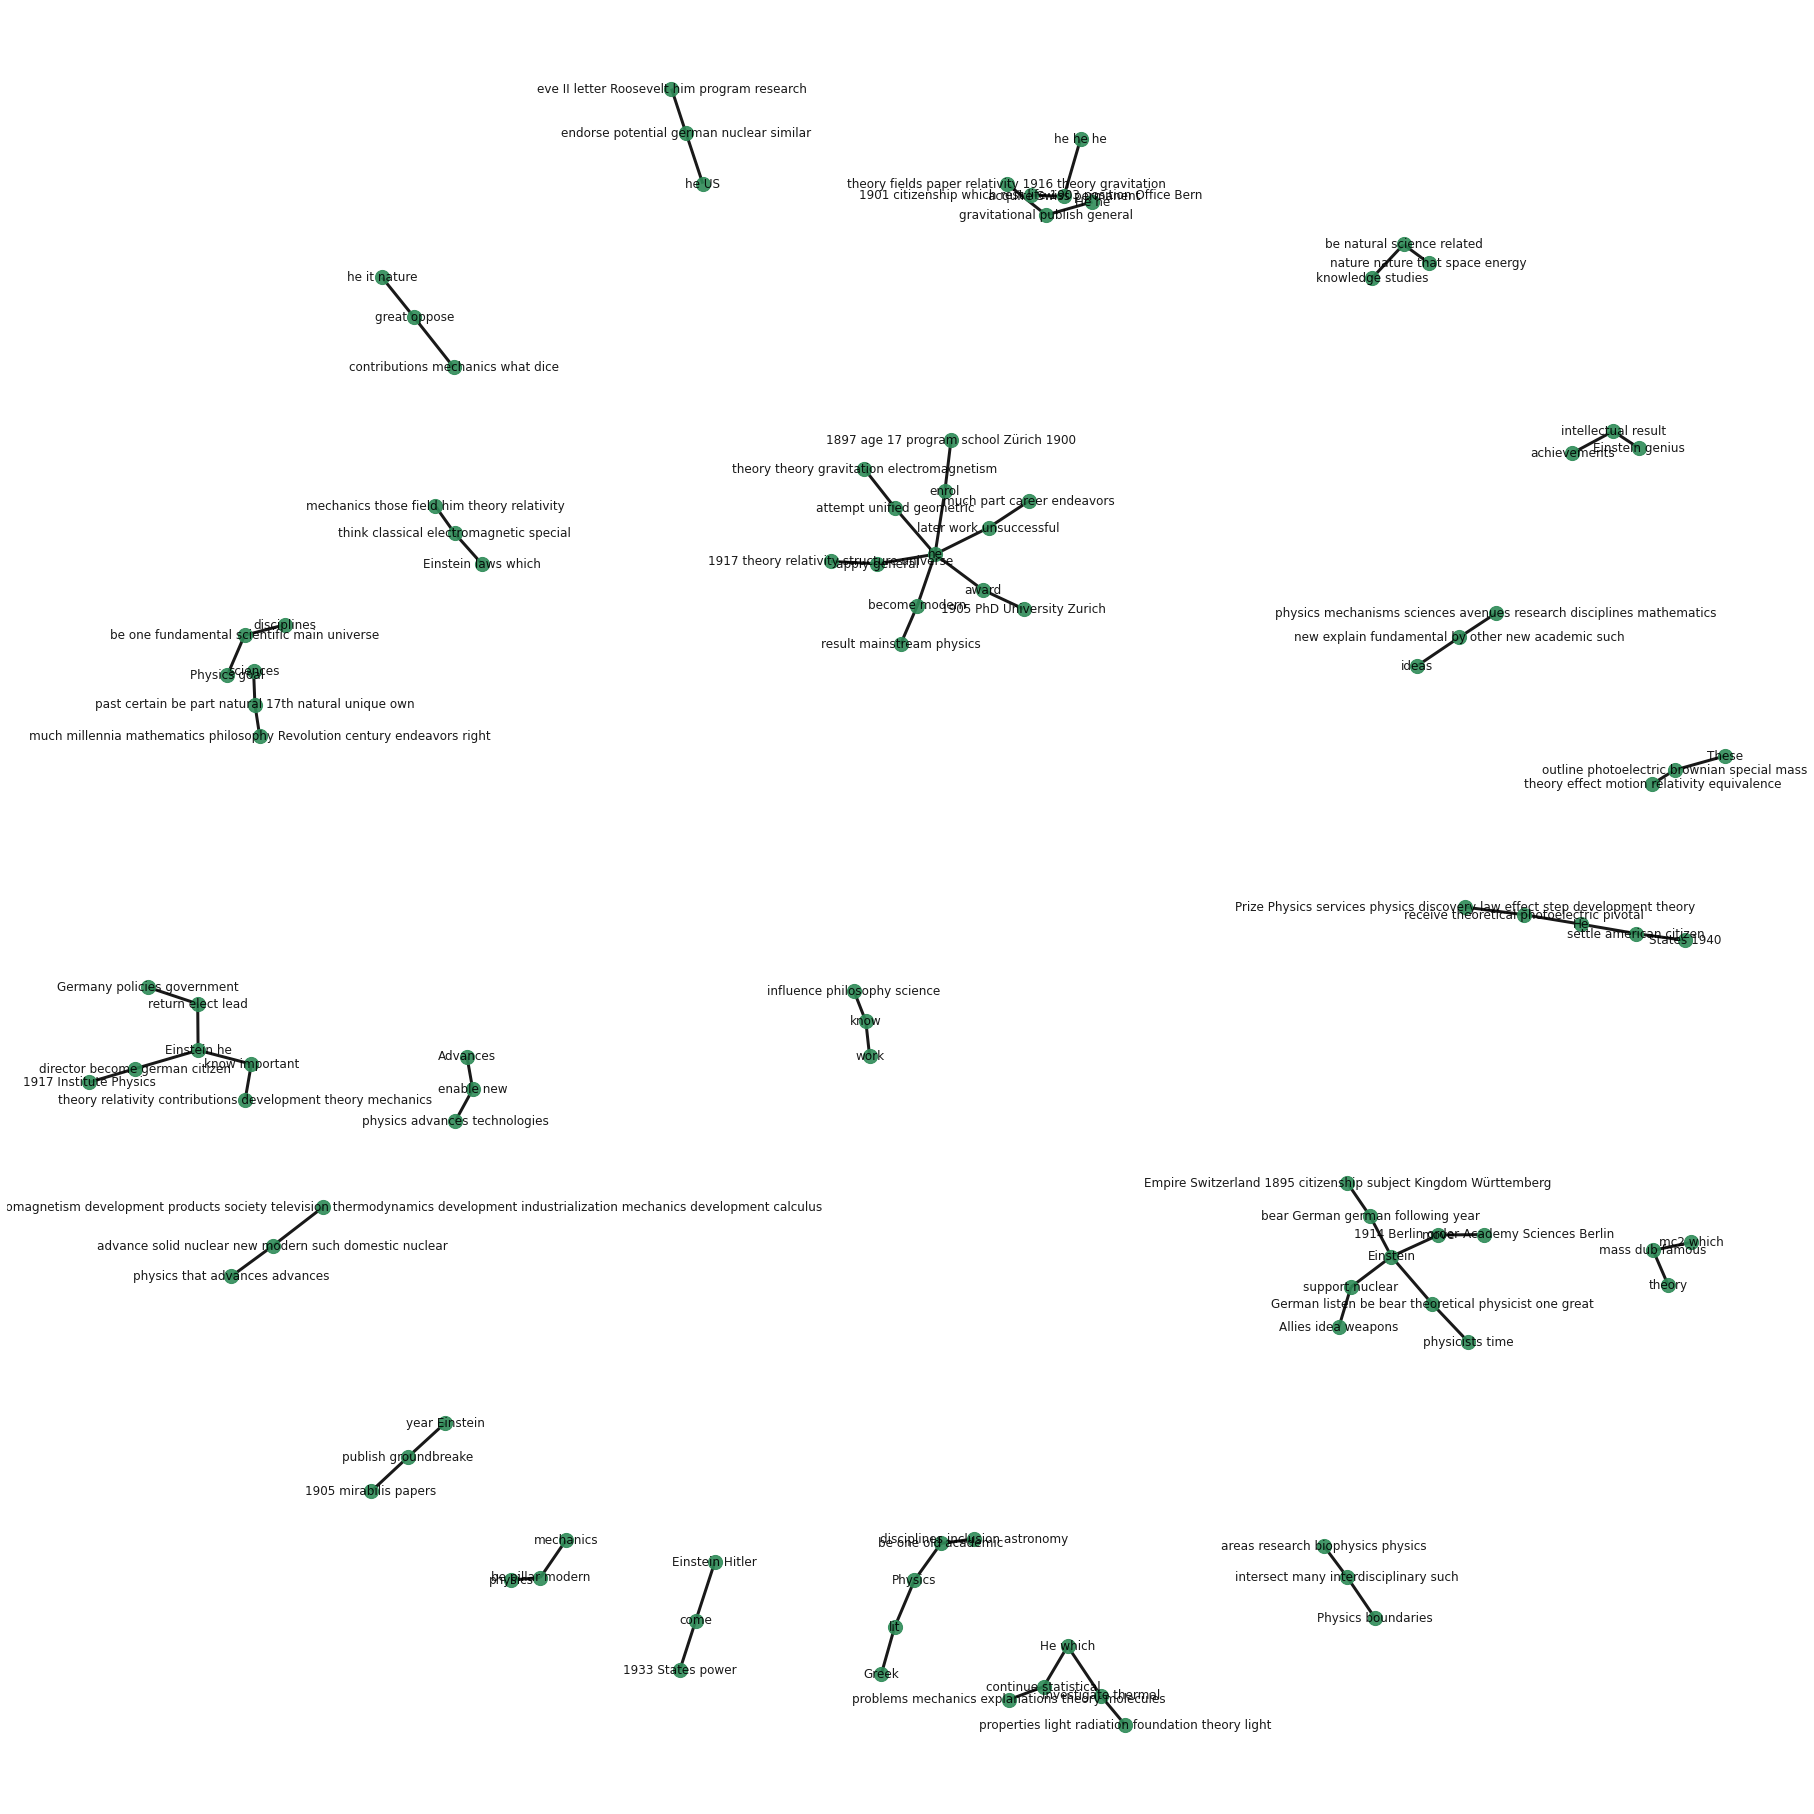

# Output Document July 31, 2021 (using distilbert and RoBERTa)

```
World War II was the biggest and deadliest war in history, involving more than
30 countries. Sparked by the 1939 Nazi invasion of Poland, the war dragged on
for six years until the Allies defeated Nazi Germany and Japan in 1945.
30 / 45  accurate predictions found

Module prediction accuracy rating (0 - 1):  0.8649182917103508 
Module Predicition accuracy rating (%):     86.49182917103508 %
 Accuracy Rating:  0.6666666666666666 
 Inaccurate List:  [41, 39, 37, 33, 32, 25, 22, 21, 18, 16, 15, 8, 7, 6, 5] 
 Accurate List:  [44, 43, 42, 40, 38, 36, 35, 34, 31, 30, 29, 28, 27, 26, 24, 23, 20, 19, 17, 14, 13, 12, 11, 10, 9, 4, 3, 2, 1, 0]

World War II was the longest and heaviest conflict in history , involving more
than 100 fronts . devastated by the imminent soviet invasion of  Poland , the
war dragged on for several months until the Allies invaded Nazi  Germany and 
Japan in 1945 . 

II
soviet
Poland
Nazi
Germany
Japan
```
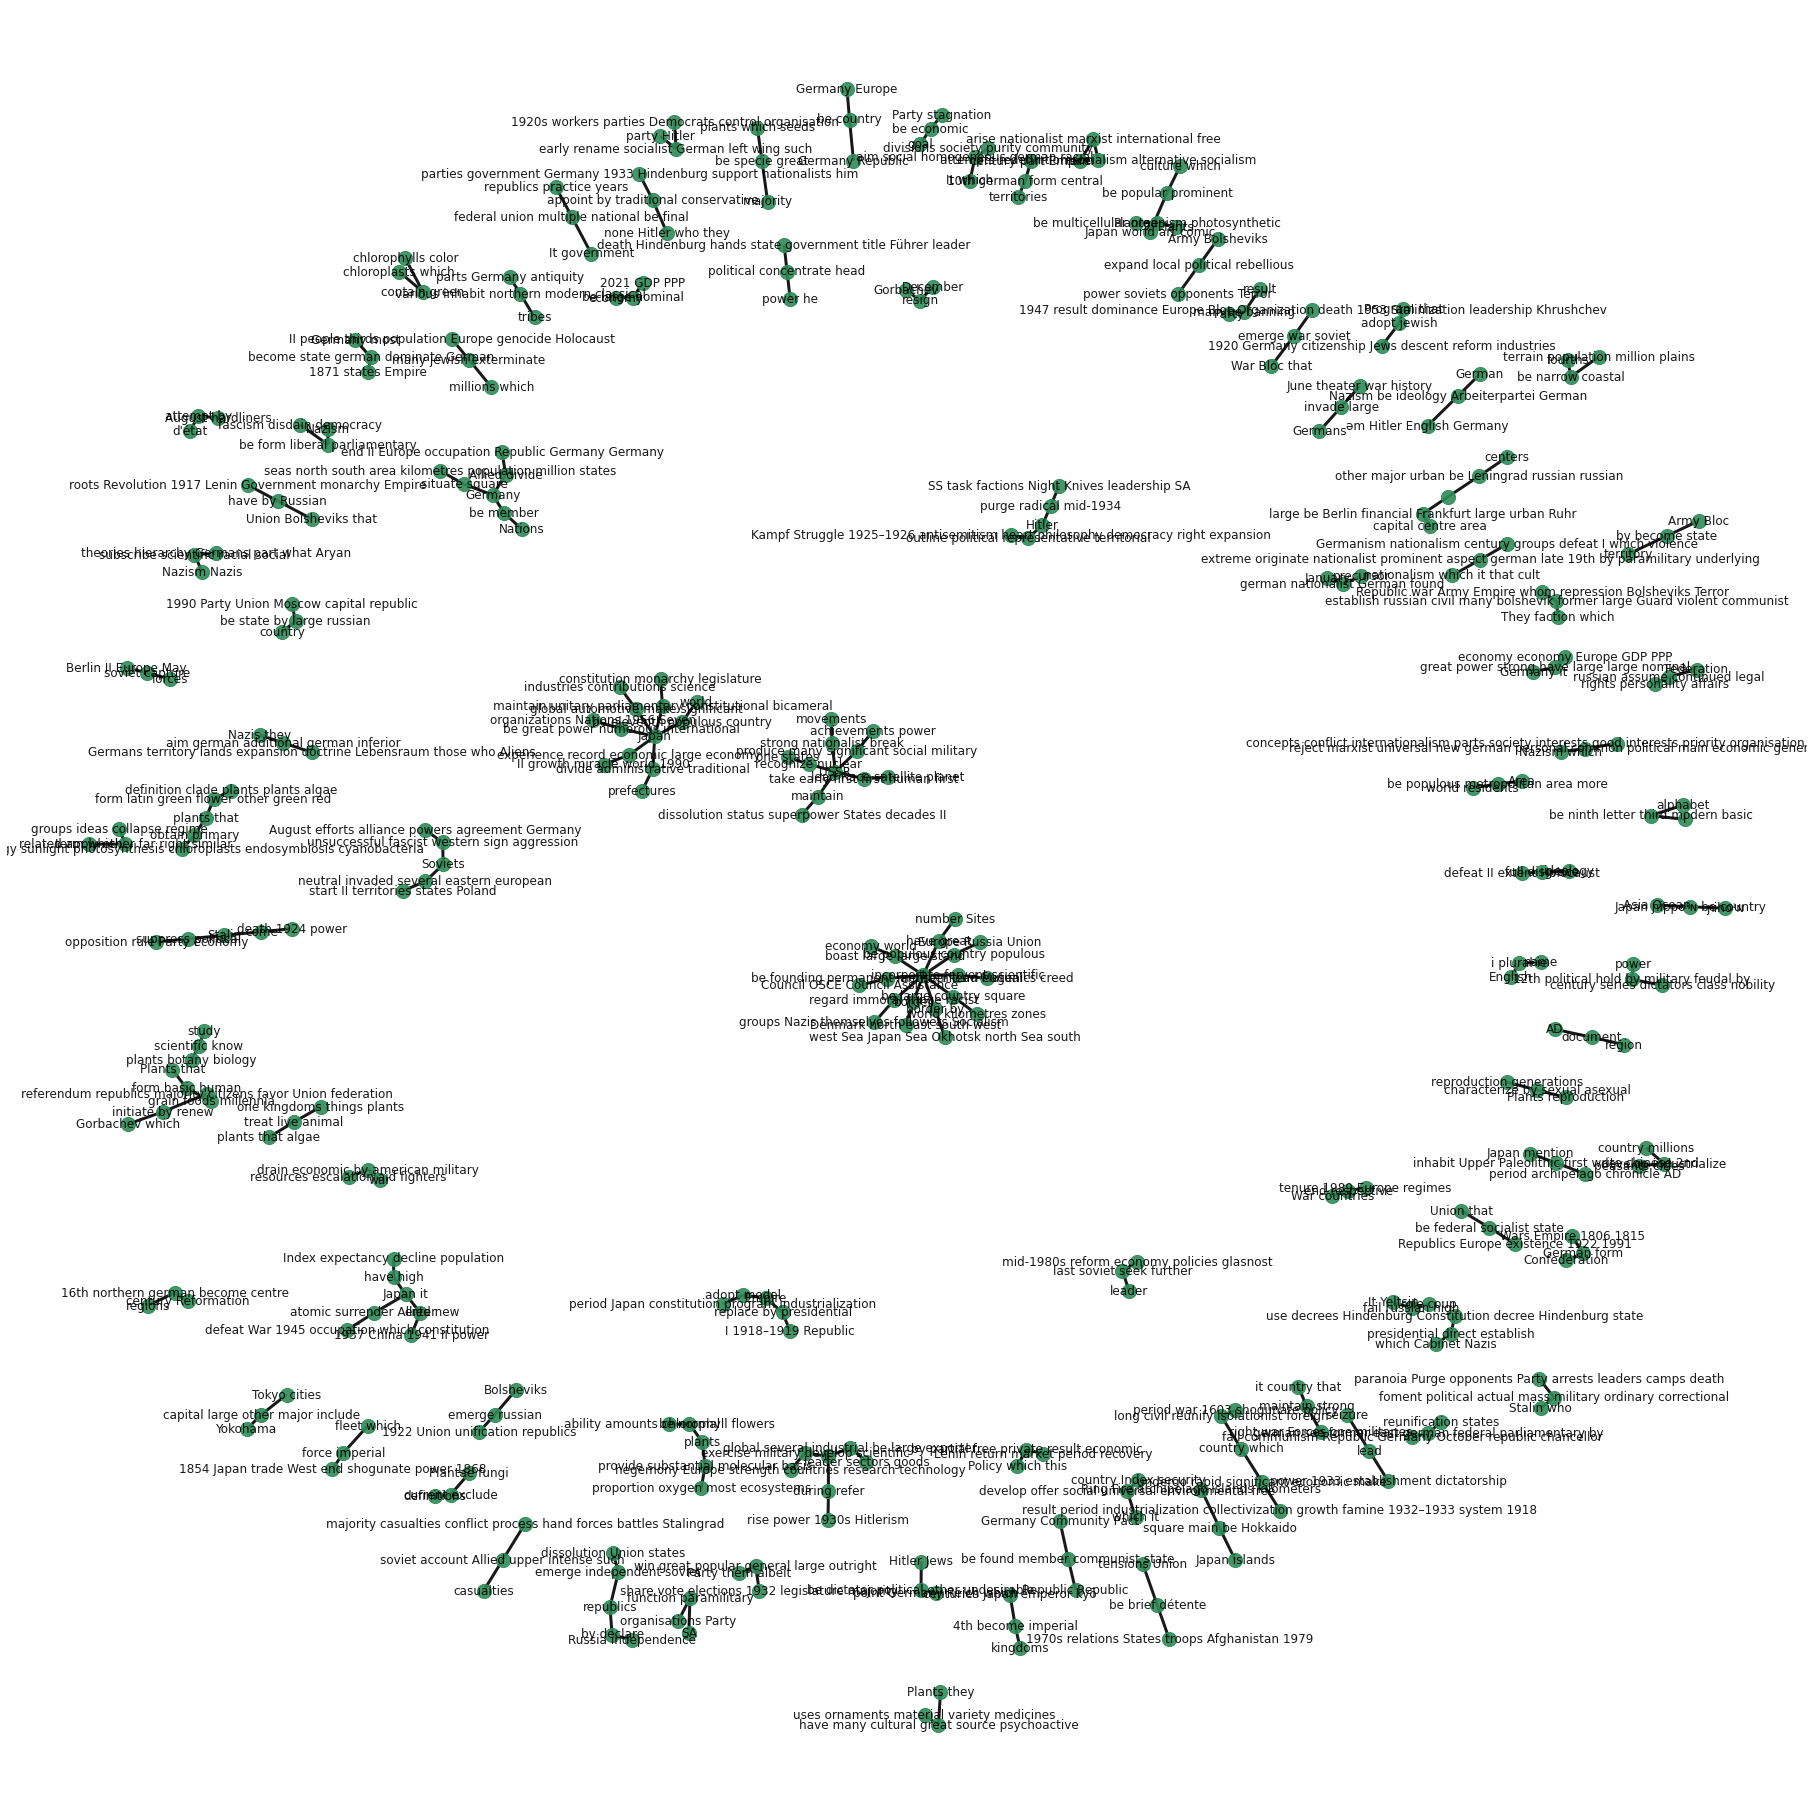

# Output Document July 29, 2021 (using distilbert and RoBERTa)

```
London is the capital and largest city of England and the United
Kingdom. Standing on the River Thames in the south-east of England,
at the head of its 50-mile (80 km) estuary leading to the North Sea,
London has been a major settlement for two millennia. Londinium was
founded by the Romans. The City of London, London's ancient core − an
area of just 1.12 square miles (2.9 km2) and colloquially known as
the Square Mile − retains boundaries that follow closely its medieval
limits. The City of Westminster is also an Inner London borough
holding city status. Greater London is governed by the Mayor of
London and the London Assembly. London is located in the southeast of
England. Westminster is located in London. London is the biggest city
in Britain. London has a population of 7 million people.
98 / 160  accurate predictions found

Module prediction accuracy rating (0 - 1):  0.817480470437705 
Module Predicition accuracy rating (%):     81.7480470437705 %
 Accuracy Rating:  0.6125 
 Inaccurate List:  [156, 149, 146, 141, 140, 136, 135, 133, 127, 126, 125, 120, 111, 110, 108, 107, 105, 98, 97, 96, 95, 93, 91, 90, 84, 83, 81, 80, 74, 71, 70, 67, 66, 65, 64, 63, 62, 58, 54, 52, 51, 49, 47, 46, 37, 36, 35, 30, 29, 27, 23, 21, 14, 9, 8] 
 Accurate List:  [159, 158, 157, 155, 154, 153, 152, 150, 148, 147, 145, 144, 142, 139, 138, 137, 134, 132, 131, 130, 129, 124, 123, 121, 119, 118, 117, 116, 114, 113, 112, 109, 106, 104, 103, 102, 101, 100, 99, 94, 92, 89, 88, 86, 85, 82, 79, 78, 77, 76, 75, 73, 72, 69, 68, 61, 60, 59, 57, 55, 53, 50, 48, 45, 44, 43, 41, 40, 39, 38, 34, 33, 32, 31, 28, 26, 25, 24, 22, 20, 19, 18, 17, 16, 15, 13, 12, 11, 10, 7, 6, 5, 4, 3, 2, 1]

London is the capital and largest city of  England in the United
Kingdom . situated on the River Thames in the west of  England , at
the mouth of the wide ( 80 km ) estuary flowing into the North Sea ,
London has been a walled city for many millennia since london was
inhabited by the Romans . The City of  London ,  the largest city
covering an area covering approximately 1 . 83 square miles ( 2 . 83
km² ) , is known as the Square Mile within municipal boundaries that
follow closely overlapping municipal boundaries . The City of
Westminster is technically an autonomous  London borough within
borough status . Greater London is governed by the city of London and
the  London borough of London is located in the west of  England
while Westminster is located in  Scotland . London is the largest
city in  Europe . London has a population of 10 million people .
```
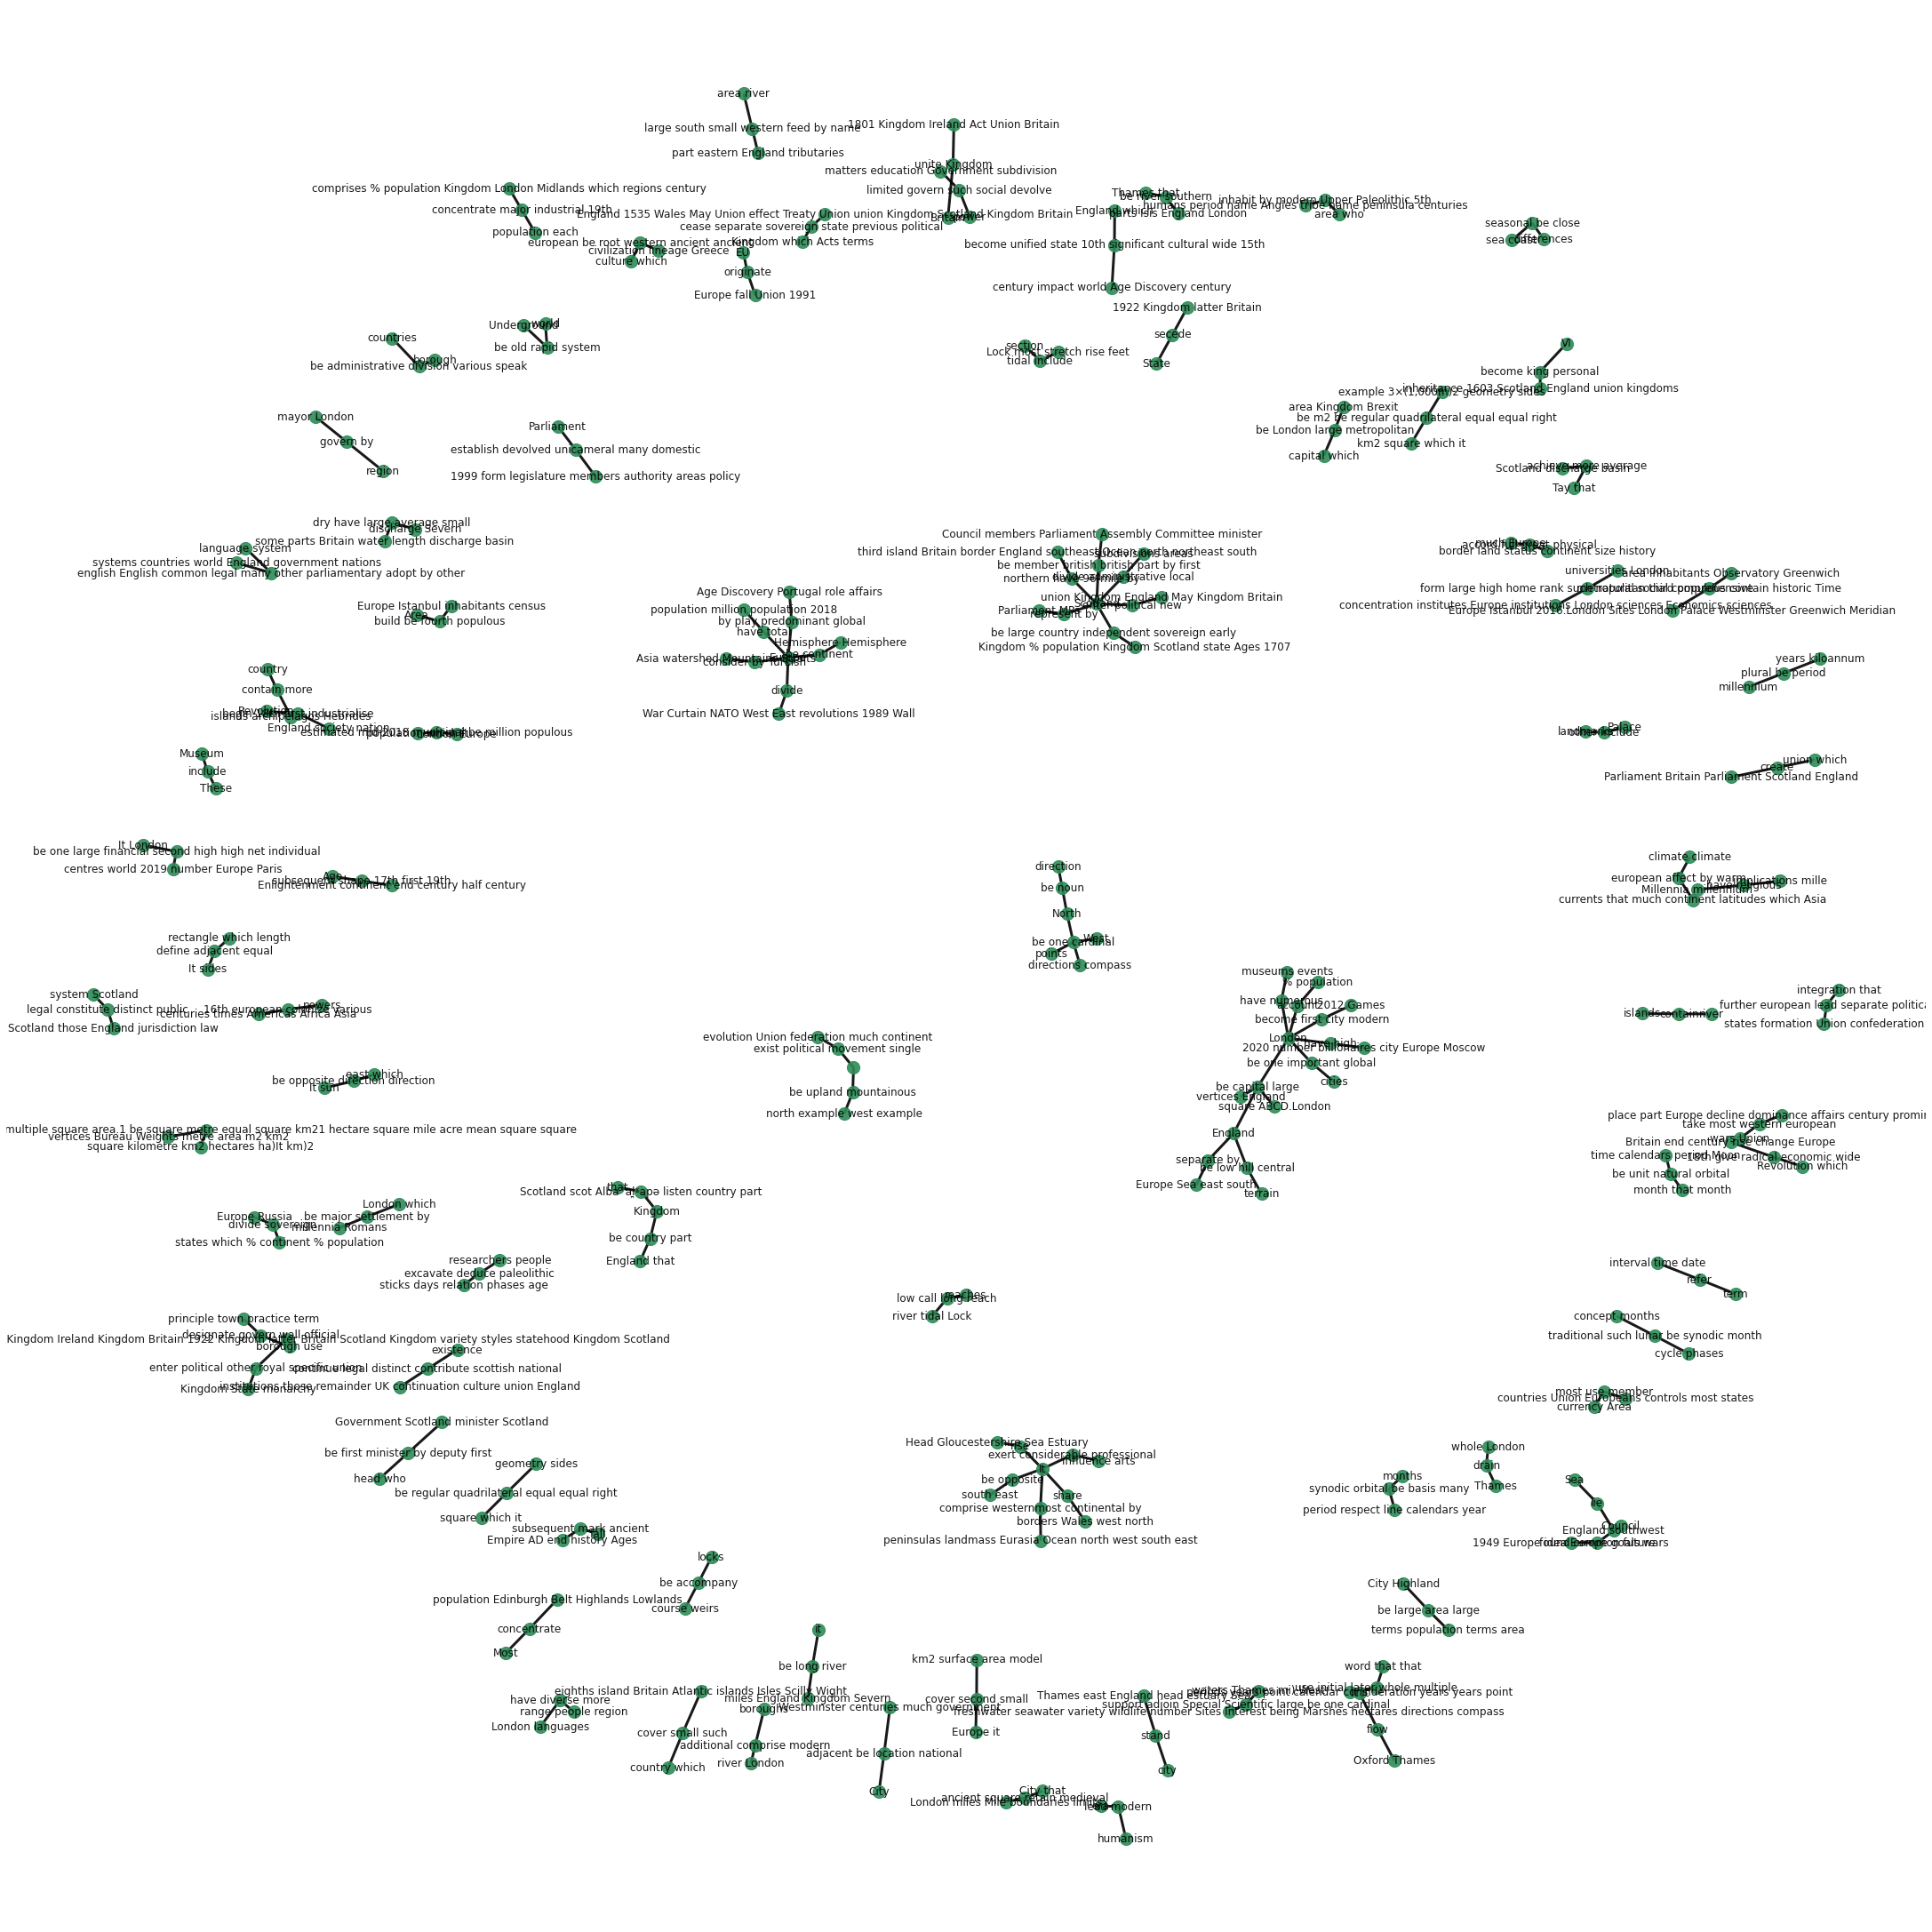

# Output Document July 25, 2021 (using distilbert and RoBERTa)
```
albert einstein was a scientist.
5 / 6  accurate predictions found

Module prediction accuracy rating (0 - 1):  0.6138640079647303 
Module Predicition accuracy rating (%):     61.386400796473026 %
 Accuracy Rating:  0.8333333333333334 
 Inaccurate List:  [4] 
 Accurate List:  [5, 3, 2, 1, 0]

 albert einstein was a physicist . 

albert
einstein
physicist
```
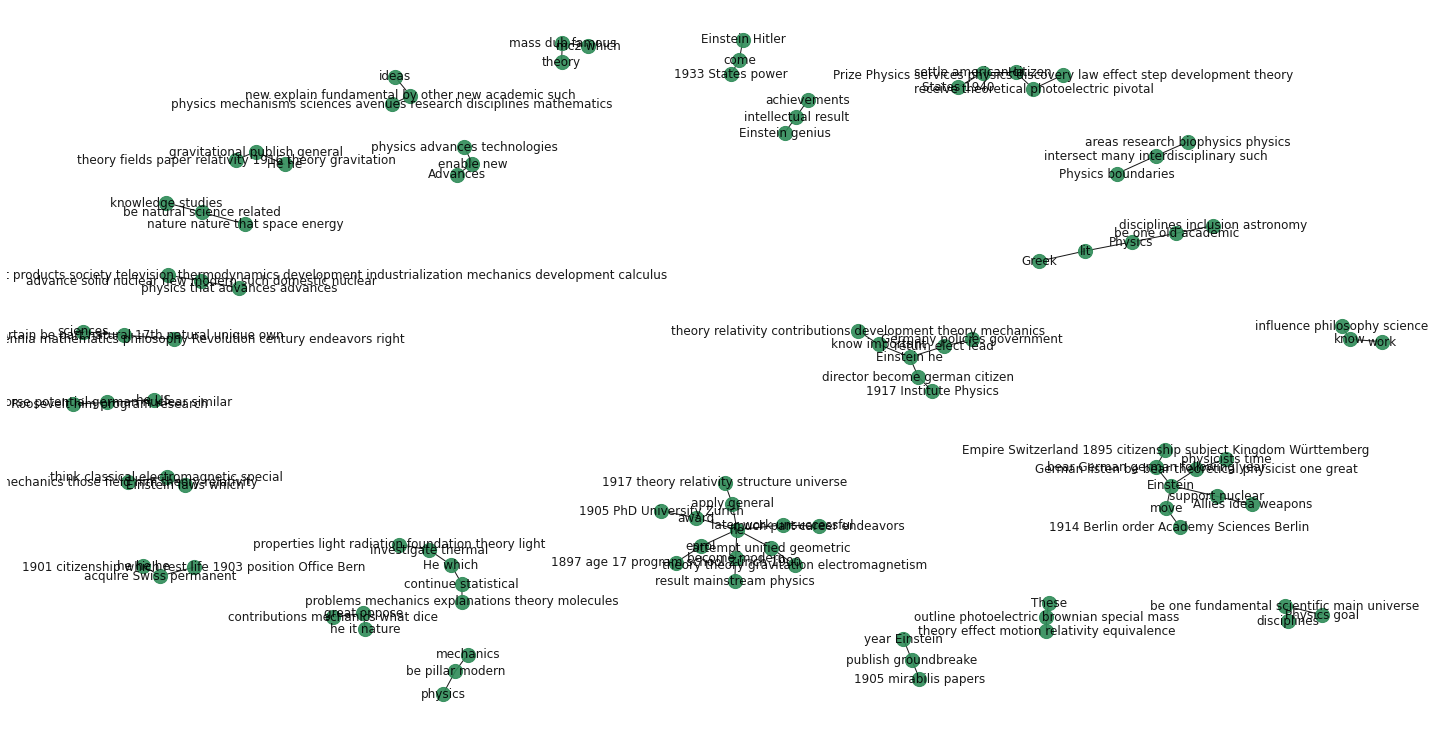

```
China is the most populated country in the world.
8 / 10  accurate predictions found

Module prediction accuracy rating (0 - 1):  0.6440447691828013 
Module Predicition accuracy rating (%):     64.40447691828012 %
 Accuracy Rating:  0.8 
 Inaccurate List:  [4] 
 Accurate List:  [9, 8, 7, 6, 5, 3, 2, 1]

 China is the most populous country in the world . 



China
country
world
```
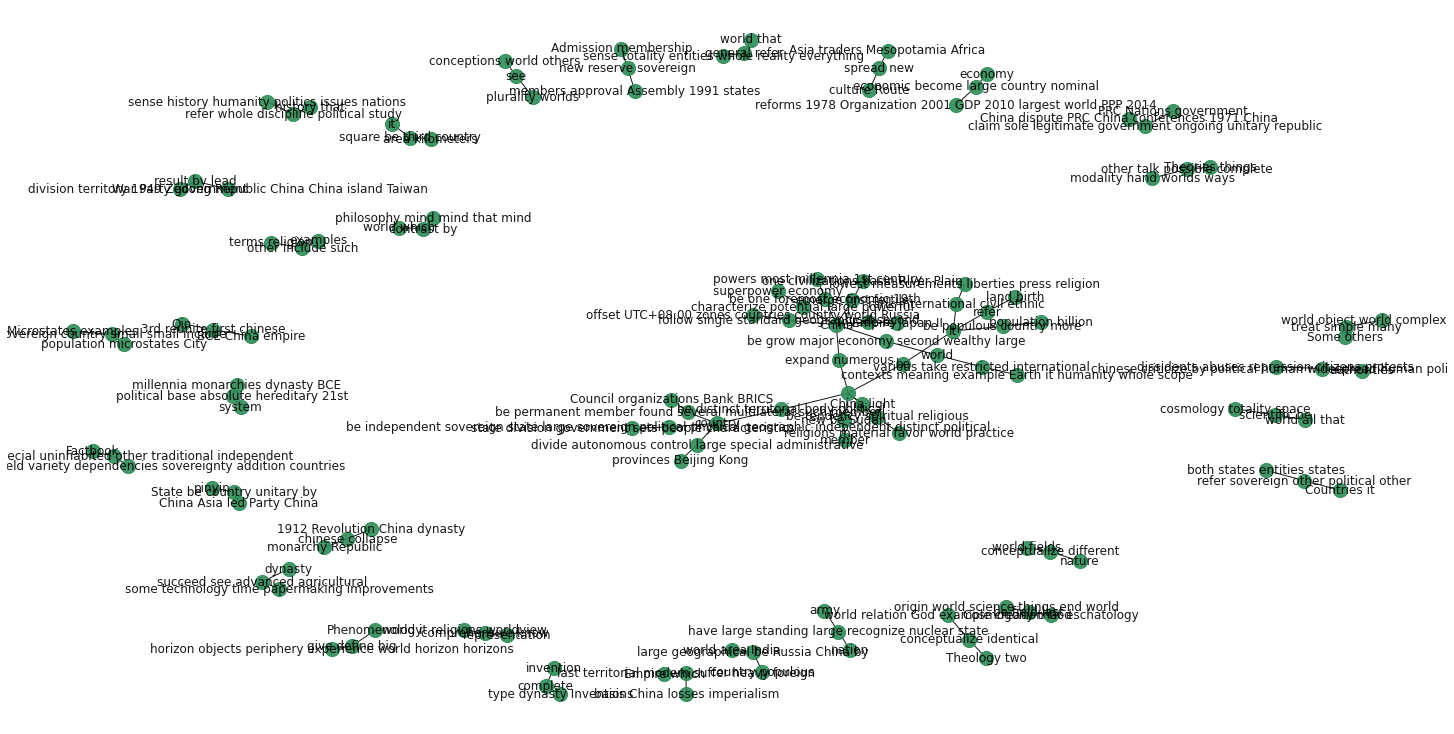


# Output Document July 20, 2021 (using distilbert)
```
Barack Obama is the 45th president of Canada.
7 / 9  accurate predictions found

Module prediction accuracy rating (0 - 1):  0.8818846046924591 
Module Predicition accuracy rating (%):     88.18846046924591 %
 Accuracy Rating:  0.7777777777777778 
 Inaccurate List:  [4, 7] 
 Accurate List:  [0, 1, 2, 3, 5, 6, 8]

 Barack Obama is the 44th president of america . 

DisambiguationError with president

```

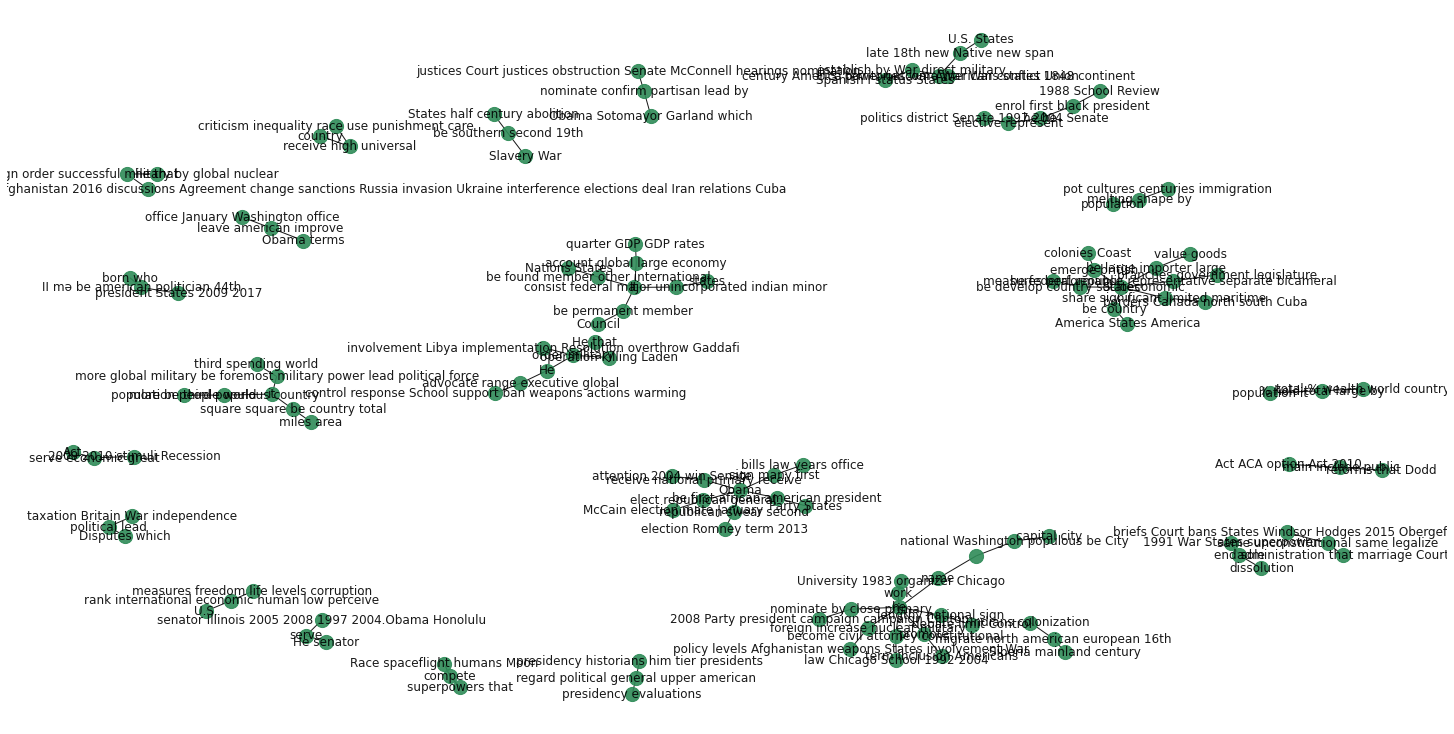

# Output Document July 17, 2021 (using distilbert)
```
Barack Obama is the 51st prime-minister of the United States.
9 / 11  accurate predictions found

Module prediction accuracy rating (0 - 1):  0.8999016004800796 
Module Predicition accuracy rating (%):     89.99016004800797 %
 Accuracy Rating:  0.8181818181818182      [4, 5]
['Barack', 'Obama', 'is', 'the', '[MASK]', 'prime-minister', 'of', 'the', 'United', 'States', '.']
['Barack', 'Obama', 'is', 'the', '44th', '[MASK]', 'of', 'the', 'United', 'States', '.']

 Barack Obama is the 44th president of the United States . 



Obama , be 44th president , States
```
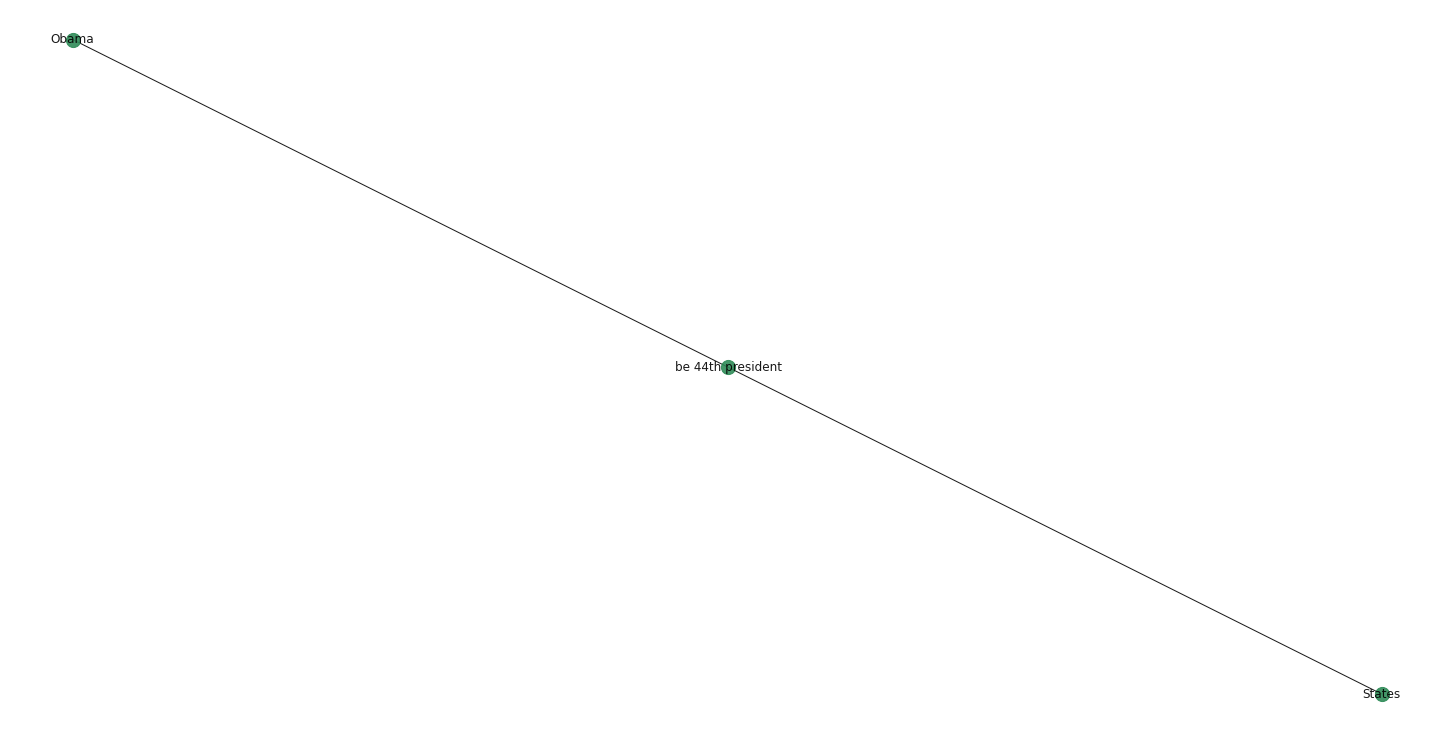

# Output Document July 9, 2021 (using distilbert)

```
Neil Armstrong, an astronaut, was the first man on the moon. : 
Module prediction accuracy rating (0 - 1):  0.5222103953361511 
Module Predicition accuracy rating (%):     52.22103953361511 %
 Accuracy Rating:  0.7142857142857143
```

```
David Beckham played soccer, a sport also referred to as football. : 
Module prediction accuracy rating (0 - 1):  0.9373887574672699 
Module Predicition accuracy rating (%):     93.73887574672699 %
 Accuracy Rating:  0.5384615384615384
```

```
Module prediction accuracy rating (0 - 1):  0.2254219631354014 
Module prediction accuracy rating (0 - 1):  0.2254219631354014 
Module Predicition accuracy rating (%):     22.54219631354014 %
 Accuracy Rating:  0.5
```

```
Barack Obama was the 44th President of the United States. : 
Module prediction accuracy rating (0 - 1):  0.8804009824991226 
Module Predicition accuracy rating (%):     88.04009824991226 %
 Accuracy Rating:  0.9090909090909091
```

```
Barack Obama was the 45th President of the United States. : 
Module prediction accuracy rating (0 - 1):  0.9968274366855622 
Module Predicition accuracy rating (%):     99.68274366855621 %
 Accuracy Rating:  0.8181818181818182
```

```
Barack Obama was the president of Canada. : 
Module prediction accuracy rating (0 - 1):  0.9008845516790945 
Module Predicition accuracy rating (%):     90.08845516790946 %
 Accuracy Rating:  0.75
```

```
Barack Obama was the prime minister of Canada. : 
Module prediction accuracy rating (0 - 1):  0.9120560308297475 
Module Predicition accuracy rating (%):     91.20560308297475 %
 Accuracy Rating:  0.7777777777777778
```